# Data Preprocessing

In [1]:
!pip install roboflow
                

     -------------------------------------- 89.9/89.9 KB 637.6 kB/s eta 0:00:00
     ---------------------------------------- 9.9/9.9 MB 4.6 MB/s eta 0:00:00
     ---------------------------------------- 64.7/64.7 KB ? eta 0:00:00
     ---------------------------------------- 7.0/7.0 MB 11.2 MB/s eta 0:00:00
     ---------------------------------------- 131.2/131.2 KB ? eta 0:00:00
     ---------------------------------------- 8.1/8.1 MB 11.8 MB/s eta 0:00:00
     -------------------------------------- 158.6/158.6 KB 9.9 MB/s eta 0:00:00
     ---------------------------------------- 73.7/73.7 KB ? eta 0:00:00
     ---------------------------------------- 1.9/1.9 MB 13.4 MB/s eta 0:00:00
     ---------------------------------------- 66.8/66.8 KB ? eta 0:00:00
     ---------------------------------------- 38.8/38.8 MB 8.4 MB/s eta 0:00:00
     --------------------------------------- 12.9/12.9 MB 10.9 MB/s eta 0:00:00
     ---------------------------------------- 54.5/54.5 KB ? eta 0:00:0

You should consider upgrading via the 'C:\Users\liort\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key="v5nYPJVr4VP4XoJRmdUs")
project = rf.workspace("leaklock").project("id-card-segmentation-hk0gw")
version = project.version(2)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to id-card-segmentation-2 in yolov5pytorch:: 100%|██████████| 9376/9376 [00:06<00:00, 1436.35it/s]


In [5]:
!pip -q install ultralytics opencv-python pillow ipywidgets matplotlib

You should consider upgrading via the 'C:\Users\liort\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


### Before this step - You must edit the file "data.yaml" inside id-card-sementation-2
### It will need to look like this:
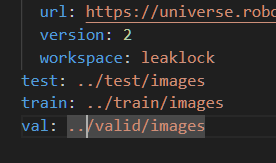

In [9]:
torch.cuda.is_available()

False

In [8]:
from ultralytics import YOLO
import torch
from pathlib import Path

FULLSET_YAML = Path("dataset/data.yaml")

model = YOLO("yolov8n.pt")
model.train(
    data=str(FULLSET_YAML),
    epochs=50,
    imgsz=640,
    batch=16,
    device=0 if torch.cuda.is_available() else "cpu",
    project="runs_sensitive",
    name="yolov8"
)


Ultralytics 8.3.241  Python-3.10.5 torch-2.9.1+cpu CPU (Intel Core i5-9600KF 3.70GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pre

KeyboardInterrupt: 

FileUpload(value=({'name': '1000_F_202261481_BD46ayTH6aBgh8rPISXqU9daMiYq77q8.jpg', 'type': 'image/jpeg', 'siz…

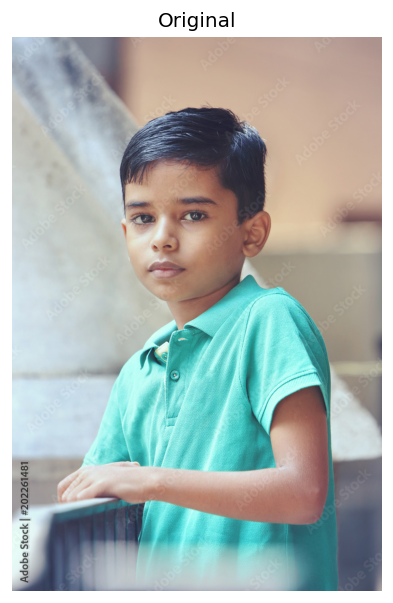

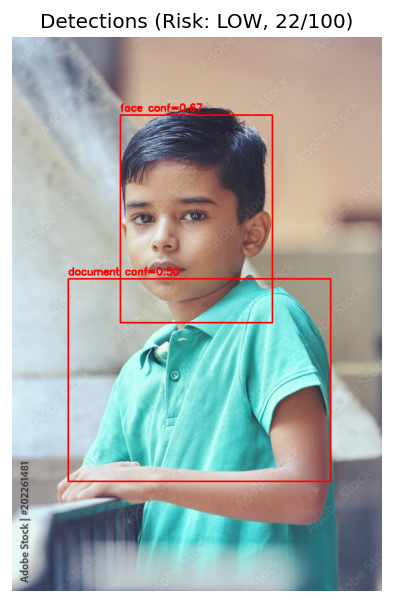

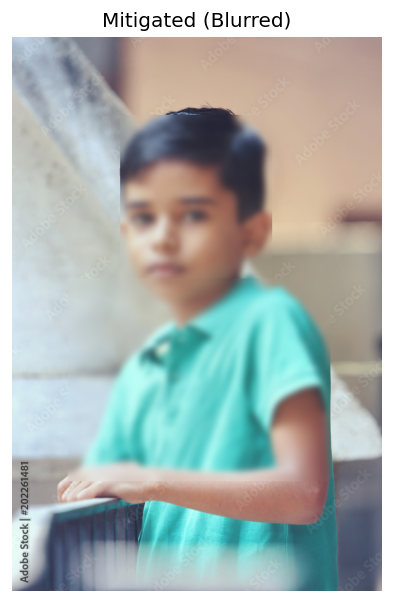

In [ ]:
from ultralytics import YOLO
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipywidgets import FileUpload
from IPython.display import display, clear_output
import io
import torch

# CONFIG
WEIGHTS_PATH = "runs_sensitive/! ! ! -> CHANGE <- ! ! !.../weights/best.pt"  

model = YOLO(WEIGHTS_PATH)
print("Loaded model. Classes:", model.names)

WEIGHTS = {"card": 40,"license-plates": 35,"document": 25,"face": 15,"code_screen": 25,
}

def pil_to_bgr(pil_img: Image.Image) -> np.ndarray:
    rgb = np.array(pil_img.convert("RGB"))
    return cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

def yolo_findings(result, names: dict) -> list:
    findings = []
    if result.boxes is None:
        return findings
    for b in result.boxes:
        cls_id = int(b.cls[0])
        conf = float(b.conf[0])
        x1, y1, x2, y2 = map(float, b.xyxy[0])
        findings.append({
            "type": names[cls_id],
            "conf": conf,
            "bbox": [int(x1), int(y1), int(x2), int(y2)]
        })
    return findings

def compute_risk_score(findings: list) -> int:
    score = 0.0
    for f in findings:
        w = WEIGHTS.get(f["type"], 10)
        score += w * f["conf"]
    return int(max(0, min(100, round(score))))

def risk_level(score: int) -> str:
    if score >= 60:
        return "HIGH"
    if score >= 30:
        return "MEDIUM"
    return "LOW"

def draw_findings(img_bgr: np.ndarray, findings: list) -> np.ndarray:
    out = img_bgr.copy()
    for f in findings:
        x1, y1, x2, y2 = f["bbox"]
        label = f'{f["type"]} conf={f["conf"]:.2f}'
        cv2.rectangle(out, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(out, label, (x1, max(20, y1 - 7)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    return out

def blur_findings(img_bgr: np.ndarray, findings: list, ksize: int = 35) -> np.ndarray:
    out = img_bgr.copy()
    if ksize % 2 == 0:
        ksize += 1
    for f in findings:
        x1, y1, x2, y2 = f["bbox"]
        x1 = max(0, x1); y1 = max(0, y1)
        x2 = min(out.shape[1], x2); y2 = min(out.shape[0], y2)
        roi = out[y1:y2, x1:x2]
        if roi.size == 0:
            continue
        out[y1:y2, x1:x2] = cv2.GaussianBlur(roi, (ksize, ksize), 0)
    return out

def show_bgr(title: str, img_bgr: np.ndarray):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()

def get_uploaded_file(uploader: FileUpload) -> dict:
    """
    Returns a single uploaded file dict with keys like:
    - 'content' (bytes)
    - 'metadata' (dict with 'name', etc.)
    Works across ipywidgets versions where .value is dict OR tuple.
    """
    v = uploader.value

    # Newer ipywidgets: dict mapping filename -> fileinfo
    if isinstance(v, dict):
        return next(iter(v.values()))

    # Some environments: tuple/list of fileinfo dicts
    if isinstance(v, (tuple, list)) and len(v) > 0:
        return v[0]

    raise ValueError("No uploaded file found in uploader.value")

# Upload widget
uploader = FileUpload(accept="image/*", multiple=False)

def on_upload_change(change):
    clear_output(wait=True)
    display(uploader)

    if not uploader.value:
        return

    uploaded = get_uploaded_file(uploader)
    content = uploaded["content"]
    filename = uploaded.get("metadata", {}).get("name", "uploaded_image")

    # Load image
    pil_img = Image.open(io.BytesIO(content))
    img_bgr = pil_to_bgr(pil_img)

    # Run YOLO
    results = model.predict(source=img_bgr, conf=0.25, verbose=False)
    r0 = results[0]
    findings = yolo_findings(r0, model.names)

    # Risk
    score = compute_risk_score(findings)
    level = risk_level(score)

    print(f"File: {filename}")
    print(f"Detections: {len(findings)}")
    print(f"Risk Score: {score}/100 | Level: {level}")
    if findings:
        for f in findings:
            print(f' - {f["type"]} (conf={f["conf"]:.2f}) bbox={f["bbox"]}')
    else:
        print("No objects detected above the confidence threshold.")

    # Display outputs
    vis = draw_findings(img_bgr, findings)
    blurred = blur_findings(img_bgr, findings, ksize=35)

    show_bgr("Original", img_bgr)
    show_bgr(f"Detections (Risk: {level}, {score}/100)", vis)
    show_bgr("Mitigated (Blurred)", blurred)

uploader.observe(on_upload_change, names="value")
display(uploader)


In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 120


In [20]:
display(uploader)

FileUpload(value=({'name': '9fdb33e6-f737-4bb0-9695-a519dad37f77.jpg', 'type': 'image/jpeg', 'size': 157733, '…